## REFERENCES:
* Pre-trained models: https://pytorch.org/docs/master/torchvision/models.html
* Tutorial 1: https://pytorch.org/tutorials/beginner/finetuning_torchvision_models_tutorial.html
* Tutorial 2: https://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html
* YouTube Playlist: https://www.youtube.com/playlist?list=PLqnslRFeH2UrcDBWF5mfPGpqQDSta6VK4
* Data Loader: https://gist.github.com/kevinzakka/d33bf8d6c7f06a9d8c76d97a7879f5cb#file-data_loader-py

In [1]:
from __future__ import division
from __future__ import print_function
import time
import os
import random
import platform
import shutil
import copy
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
from torchvision import models, transforms
from torchvision.datasets import ImageFolder as IF
from torch.utils.data import DataLoader as DL

from prepare import prepare_image_folders

print("Python Version:", platform.python_version())
print("PyTorch Version:", torch.__version__)
print("Torchvision Version:", torchvision.__version__.split('a')[0])

Python Version: 3.7.6
PyTorch Version: 1.5.0
Torchvision Version: 0.6.0


In [2]:
data_dir = os.path.join(os.path.realpath(''), 'data')
category_names = ["bear", "elephant", "leopard", "zebra"]
num_categories = 4
batch_size = 16
num_epochs = 5
input_size = 224  # for alexnet

# All pre-trained models expect input images normalized in the same way
# For details: https://pytorch.org/docs/master/torchvision/models.html
normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])

In [3]:
# Below function arranges the image folders in a way that the data loader requires
# For details: https://pytorch.org/docs/stable/torchvision/datasets.html#imagefolder

prepare_image_folders(data_dir, category_names, 2020)  # comment out if already prepared

bear       -> Divided into 224 train / 56 val / 70 test   -> Copied!
elephant   -> Divided into 224 train / 56 val / 70 test   -> Copied!
leopard    -> Divided into 224 train / 56 val / 70 test   -> Copied!
zebra      -> Divided into 224 train / 56 val / 70 test   -> Copied!


In [7]:
# Data augmentation and normalization for training
# Just resizing and normalization for val and test
trans_dict = {
    'train': transforms.Compose([transforms.RandomResizedCrop(input_size),
                                 transforms.RandomHorizontalFlip(),
                                 transforms.ToTensor(),
                                 normalize
                                ]),

    'val': transforms.Compose([transforms.Resize(input_size),
                               transforms.CenterCrop(input_size),
                               transforms.ToTensor(),
                               normalize
                              ]),

    'test': transforms.Compose([transforms.Resize(input_size),
                                transforms.CenterCrop(input_size),
                                transforms.ToTensor(),
                                normalize
                               ])
}

# Create training, validation and test datasets
imgfolders = {x: IF(os.path.join(data_dir, 'prepared', x), trans_dict[x])
              for x in ['train', 'val', 'test'] }

# Create training, validation and test dataloaders
# If using CUDA, num_workers should be set to 1 and pin_memory to True
dataloaders = {x: DL(imgfolders[x], batch_size=batch_size, shuffle=True, num_workers=1, pin_memory=False)
               for x in ['train', 'val', 'test'] }

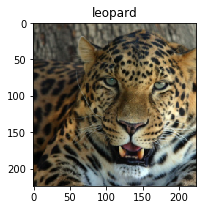

In [8]:
def display_single(img_id=-1):
    folder = imgfolders['test']
    if img_id == -1:
        img_id = random.randint(0, len(folder))
    tensor = folder.__getitem__(img_id)
    img = tensor[0].permute(1, 2, 0)
    label = tensor[1]
    img_denorm = img * np.array(normalize.std) + np.array(normalize.mean) # denormalization
    plt.figure(figsize = (3, 3))
    plt.imshow(np.clip(img_denorm, 0, 1))
    plt.title(category_names[label])
    plt.show()

display_single(153)  # 153 is arbitrarily chosen

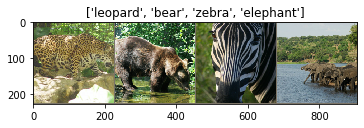

In [25]:
# Visualize N images
def display_multiple(N):
    
    # Get a batch of test data
    batch = next(iter(dataloaders['test']))
    
    if N > batch_size:
        print("N must be less than batch_size={}".format(batch_size))
        return
    
    images, categories = batch
    
    title=[category_names[x] for x in categories[0:N]]
    
    # Get a grid of N images from batch
    grid = torchvision.utils.make_grid(images[0:N])
    
    grid = grid.permute(1, 2, 0)  # needed since PyTorch Tensors are channel-first
    grid = grid * np.array(normalize.std) + np.array(normalize.mean) # denormalization
    grid = np.clip(grid, 0, 1)
    plt.figure(figsize = (N*1.5, 1.5))  # set an arbitrary size
    plt.imshow(grid)
    plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated

display_multiple(4)

In [26]:
def initialize_model(out_size, use_pretrained):

    model = models.alexnet(pretrained=use_pretrained)

    # initially disable all parameter updates
    if use_pretrained:
        for param in model.parameters():
            param.requires_grad = False

    # reshape the output layer
    in_size = model.classifier[6].in_features
    model.classifier[6] = nn.Linear(in_size, out_size)

    if use_pretrained:
        params_to_update = []
        for param in model.parameters():
            if param.requires_grad:
                params_to_update.append(param)  # parameters of reshaped layer
    else:
        params_to_update = model.parameters()  # parameters of all layers
        
    for name, param in model.named_parameters():
        print("{} \t requires_grad = {}".format(name, param.requires_grad))
    
    return model, params_to_update

In [27]:
def train_model(model, dataloaders, criterion, optimizer, num_epochs, use_pretrained):
    since = time.time()

    val_acc_history = []

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    # Get model outputs and calculate loss
                    outputs = model(inputs)
                    loss = criterion(outputs, labels)

                    _, preds = torch.max(outputs, 1)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                batch_loss = loss.item() * inputs.size(0)
                batch_correct = torch.sum(preds == labels.data)
                num_batches = len(dataloaders[phase].dataset) // batch_size
                running_loss += batch_loss
                running_corrects += batch_correct


            epoch_loss = running_loss / len(dataloaders[phase].dataset)
            epoch_acc = running_corrects.double() / len(dataloaders[phase].dataset)

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
            if phase == 'val':
                val_acc_history.append(epoch_acc)

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)

    # save best model weights
    if use_pretrained:
        model_path = './models/alexnet_pretrained.pth'
    else:
        model_path = './models/alexnet_scratch.pth'
    torch.save(best_model_wts, model_path)

    return model, val_acc_history

In [28]:
def test_model(model):
    was_training = model.training  # store mode
    model.eval()  # run in evaluation mode

    with torch.no_grad():
        running_corrects = 0
        for inputs, labels in dataloaders['test']:
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            batch_correct = torch.sum(preds == labels.data)
            running_corrects += batch_correct
        
        ds = dataloaders['test'].dataset
        acc = running_corrects.double() / len(ds)

        print(' {}/{} predictions are correct -> Test Acc: {:.4f}'
              .format(running_corrects, len(ds), acc))

    model.train(mode=was_training)  # reinstate the previous mode

    return acc

## PRETRAINED:

In [10]:
# Initialize model
model_pretrained, params_to_update_pretrained = initialize_model(out_size=num_categories, use_pretrained=True)

# print("\n\n", model_pretrained)

# Setup the optimizer 
optimizer_pretrained = optim.SGD(params_to_update_pretrained, lr=0.001, momentum=0.9)

# Setup the loss function
criterion = nn.CrossEntropyLoss()

# Detect if we have a GPU available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Send the model to CPU or GPU
model_pretrained = model_pretrained.to(device)

features.0.weight 	 requires_grad = False
features.0.bias 	 requires_grad = False
features.3.weight 	 requires_grad = False
features.3.bias 	 requires_grad = False
features.6.weight 	 requires_grad = False
features.6.bias 	 requires_grad = False
features.8.weight 	 requires_grad = False
features.8.bias 	 requires_grad = False
features.10.weight 	 requires_grad = False
features.10.bias 	 requires_grad = False
classifier.1.weight 	 requires_grad = False
classifier.1.bias 	 requires_grad = False
classifier.4.weight 	 requires_grad = False
classifier.4.bias 	 requires_grad = False
classifier.6.weight 	 requires_grad = True
classifier.6.bias 	 requires_grad = True


In [11]:
# Train and evaluate
model_pretrained, hist_pretrained = train_model(model_pretrained, dataloaders, criterion,
                                                optimizer_pretrained, num_epochs=num_epochs,
                                                use_pretrained=True)

Epoch 0/4
----------
train Loss: 0.1728 Acc: 0.9431
val Loss: 0.0199 Acc: 0.9911

Epoch 1/4
----------
train Loss: 0.0924 Acc: 0.9654
val Loss: 0.0191 Acc: 0.9955

Epoch 2/4
----------
train Loss: 0.0664 Acc: 0.9743
val Loss: 0.0331 Acc: 0.9955

Epoch 3/4
----------
train Loss: 0.0616 Acc: 0.9788
val Loss: 0.0134 Acc: 0.9955

Epoch 4/4
----------
train Loss: 0.0720 Acc: 0.9754
val Loss: 0.0178 Acc: 0.9955

Training complete in 1m 57s
Best val Acc: 0.995536


In [27]:
score_pretrained = test_model(model_pretrained)

 275/280 predictions are correct -> Test Acc: 0.9821


## FROM SCRATCH:

In [49]:
# Initialize the non-pretrained version of the model used for this run
model_scratch, params_to_update_scratch = initialize_model(out_size=num_categories, use_pretrained=False)

print("\n\n", model_scratch)

# Setup the optimizer 
optimizer_scratch = optim.SGD(params_to_update_scratch, lr=0.001, momentum=0.9)

# Send the model to CPU or GPU
model_scratch = model_scratch.to(device)

features.0.weight 	 requires_grad = True
features.0.bias 	 requires_grad = True
features.3.weight 	 requires_grad = True
features.3.bias 	 requires_grad = True
features.6.weight 	 requires_grad = True
features.6.bias 	 requires_grad = True
features.8.weight 	 requires_grad = True
features.8.bias 	 requires_grad = True
features.10.weight 	 requires_grad = True
features.10.bias 	 requires_grad = True
classifier.1.weight 	 requires_grad = True
classifier.1.bias 	 requires_grad = True
classifier.4.weight 	 requires_grad = True
classifier.4.bias 	 requires_grad = True
classifier.6.weight 	 requires_grad = True
classifier.6.bias 	 requires_grad = True


 AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool

In [50]:
# Train and evaluate
model_scratch, hist_scratch = train_model(model_scratch, dataloaders, criterion,
                                          optimizer_scratch, num_epochs=num_epochs, use_pretrained=False)

Epoch 0/4
----------
train Loss: 1.3863 Acc: 0.2545
val Loss: 1.3857 Acc: 0.2500

Epoch 1/4
----------
train Loss: 1.3848 Acc: 0.2578
val Loss: 1.3847 Acc: 0.2500

Epoch 2/4
----------
train Loss: 1.3834 Acc: 0.2533
val Loss: 1.3824 Acc: 0.2500

Epoch 3/4
----------
train Loss: 1.3803 Acc: 0.2533
val Loss: 1.3782 Acc: 0.2679

Epoch 4/4
----------
train Loss: 1.3723 Acc: 0.2556
val Loss: 1.3701 Acc: 0.2500

Training complete in 5m 17s
Best val Acc: 0.267857


In [51]:
score_scratch = test_model(model_scratch)

 82/280 predictions are correct -> Test Acc: 0.2929


In [ ]:
# TO DO: save checkpoints and resume training

## PLOTS:

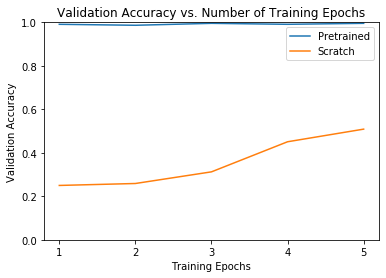

In [24]:
# Plot the training curves of validation accuracy vs. number
# of training epochs for the transfer learning method and
# the model trained from scratch
ohist = []
shist = []

ohist = [h.cpu().numpy() for h in hist]
shist = [h.cpu().numpy() for h in scratch_hist]

plt.title("Validation Accuracy vs. Number of Training Epochs")
plt.xlabel("Training Epochs")
plt.ylabel("Validation Accuracy")
plt.plot(range(1,num_epochs+1),ohist,label="Pretrained")
plt.plot(range(1,num_epochs+1),shist,label="Scratch")
plt.ylim((0,1.))
plt.xticks(np.arange(1, num_epochs+1, 1.0))
plt.legend()
plt.show()